# Intro into Frequency Series

Besides the stacked series that were introduced in earlier Notebooks, there is another way to create series, i.e we can make a Frequency. A Frequency plots the data in fixed bins, for instance daily, weekly or monthly (I.e. the time perdiod). It has a set of fixed bins into which it will plot the data, for instance 4 (I.e. the time window). Because multiple payments can occur in a time-window, the frequency needs to aggregate the data within the time period/time window on a specific key, for instance the customer or card identitifer.

If we were to plot for example a 10 day aggregate sum and count on a customer it might look like below picture. There would be 10 bins; T-9 till T on the 1st dimension. Per each bin we would have 2 features in the 2nd dimension. The features would aggregate the count and sum per day for a specific customer.


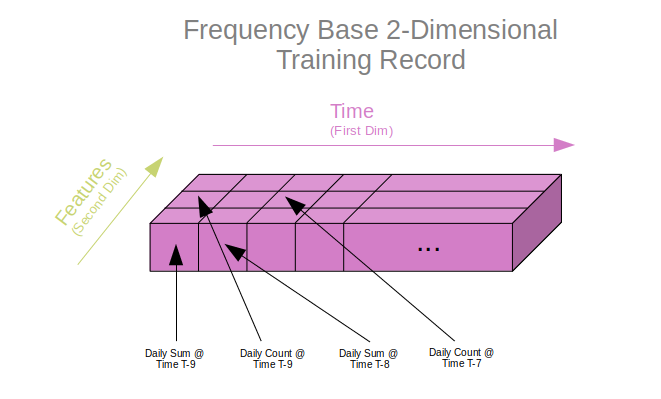


We could obviously also use different aggregators, like max, min, mean, stddev and we could have aggregated on different time periods like weeks or months.

---
#### Note on the data set 
The data set used here (https://www.kaggle.com/ntnu-testimon/banksim1) is not particulary complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

Two additional field from the input is used. 
- The __step__ field, in the output we can see it is an increasing integer number.
- The __customer__ identifier. We'll need this to build series per each customer. We are using the string type here rather than categorical because the values have high cardinality.


The __step__ field in not all that useful, we would rather have a real date. We can convert the step field using a `FeatureExpression`, they allow us to run free-form expressions. We give it a name, a type, tell it the function to call and the parameter features to feed it

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

base_features = ft.TensorDefinition(
    'base', 
    [
        customer,
        date_time,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    
df

2022-05-26 17:00:05.500 d373c7.engines.common          INFO     Start Engine...
2022-05-26 17:00:05.501 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-05-26 17:00:05.501 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-05-26 17:00:05.502 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2022-05-26 17:00:05.732 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-05-26 17:00:05.732 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-05-26 17:00:05.739 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 8)
2022-05-26 17:00:06.048 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-05-26 17:00:06.056 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: base


,customer,date,age,gender,merchant,category,amount,fraud
0,C1093826151,2020-01-01,4,M,M348934600,es_transportation,4.55,0
1,C352968107,2020-01-01,2,M,M348934600,es_transportation,39.68,0
2,C2054744914,2020-01-01,4,F,M1823072687,es_transportation,26.89,0
3,C1760612790,2020-01-01,3,M,M348934600,es_transportation,17.25,0
4,C757503768,2020-01-01,5,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...
594638,C1753498738,2020-06-28,3,F,M1823072687,es_transportation,20.53,0
594639,C650108285,2020-06-28,4,F,M1823072687,es_transportation,50.73,0
594640,C123623130,2020-06-28,2,F,M349281107,es_fashion,22.44,0
594641,C1499363341,2020-06-28,5,M,M1823072687,es_transportation,14.46,0


## Build Series

At this point we have more or less the same set-up as the example for the FeedForward classifier, execpt that there is a date and a customer id. With these 2 new feature we can build a __frequency series__ from our data.

Frequencies are based on grouper features. They need to know on which key they need to aggregate and have information on the time period/time window to use.

We call the `to_series_frequencies`, we ask it to use our *features* TensorDefinition, read from *file* and use the *date_time* as time field

This will create a frequency that shows the aggregated sum/count for the customer over the last 5 days. Note how this is different than the *stacked* series; here we are aggregating, and we report in __time bins__, we get the last 5 days instead of the last 5 payments.  

The output Numpy Array will for *each payment* contain a rank-2 array. It has the frequency length (5) as first dimension and the number of features as the second. 

And because we have *594642* individual payments, that turns into a rank-3 tensor. Now having the batch as first dimension, the time as second dimension and the features as third dimension.

The output print shows we are getting a `NumpyList` with 1 list, containing the GrouperFeatures with length 5, there are 2 GrouperFeatures with that length.


In [5]:
# This feature will return the 5 day sum of the amount, for the customer
amount_cust_5d_sum = ft.FeatureGrouper(
    'amount_cust_5d_sum',                # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer,                            # Group over customer
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    5,                                   # Aggregate 5 days
    ft.AGGREGATOR_SUM                    # Take the sum over the period elements.
)
# This feature will return the 5 day max of the amount, for the customer
amount_cust_5d_cnt = ft.FeatureGrouper(
    'amount_cust_5m_cnt',                # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer,                            # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    5,                                   # Aggregate 5 days
    ft.AGGREGATOR_COUNT                  # Take the count over the period elements.
)


features = ft.TensorDefinition(
    'learning', 
    [
        amount_cust_5d_sum,
        amount_cust_5d_cnt
    ])


with en.EnginePandasNumpy(num_threads=2) as e:
    np_ser = e.to_series_frequencies(features, file, time_feature=date_time, inference=False)
    
print(np_ser.shapes)
print(np_ser.dtype_names)

2022-05-26 17:00:11.553 d373c7.engines.common          INFO     Start Engine...
2022-05-26 17:00:11.553 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-05-26 17:00:11.554 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-05-26 17:00:11.554 d373c7.engines.panda_numpy     INFO     Building Panda for : InternalFrequenciesTime from file ../../../../data/bs140513_032310.csv
2022-05-26 17:00:11.706 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-05-26 17:00:11.706 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-05-26 17:00:11.712 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 3)
2022-05-26 17:00:12.022 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-05-26 17:00:12.029 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: InternalFrequenciesTime
2022-05-26 17:00:12

[(594643, 5, 2)]
['float32']


## Investigate series content
We can look at a specific example to understand how the frequency logic works.
Let's filter down the `df` Pandas dataframe, take one customer and records smaller than 7/1/2020.

In [6]:
df[(df['customer'] == 'C1753498738') & (df['date'] < dt.datetime(2020,1 ,20))]

,customer,date,age,gender,merchant,category,amount,fraud
1588,C1753498738,2020-01-01,3,F,M348934600,es_transportation,20.86,0
2712,C1753498738,2020-01-02,3,F,M348934600,es_transportation,11.70,0
7185,C1753498738,2020-01-03,3,F,M348934600,es_transportation,6.50,0
8869,C1753498738,2020-01-04,3,F,M855959430,es_hyper,82.06,0
12149,C1753498738,2020-01-05,3,F,M1053599405,es_health,24.19,0
13351,C1753498738,2020-01-06,3,F,M1823072687,es_transportation,23.19,0
16102,C1753498738,2020-01-07,3,F,M1823072687,es_transportation,25.00,0
18602,C1753498738,2020-01-08,3,F,M1823072687,es_transportation,42.43,0
21978,C1753498738,2020-01-09,3,F,M1823072687,es_transportation,9.78,0
25116,C1753498738,2020-01-10,3,F,M1823072687,es_transportation,11.89,0


Now slice the output `NumpyList` object we got from the `to_series_frequency` function to the last row we have in the previous cell. Record with index number __48331__. From than take the first list.

That gives us a Numpy array of Rank 3, the first dimension is the batch *(1)*, as we selected one record, the second dimension is the time *(5)*, the third dimension is the feature dimension *(2)*, as we have a sum and a count feature in this series.

These are the aggregated amounts for the last 5 days, so from 15/01/2020 till 19/01/2020.

The last entry in the numpy shows that on the 19th there were 2 payments for a total sum of 83.85. The second to last row shows that one day earlier, on the 18th, there was one payment for a total sum of 10.94, on the 17th there were 2 payments for a total of 6.78... and so forth....


In [7]:
dl=np_ser[48331]
print(dl.lists[0].shape)
print(dl.lists[0][0, :, :])

(1, 5, 2)
[[ 53.98   1.  ]
 [205.5    1.  ]
 [  6.78   2.  ]
 [ 10.94   1.  ]
 [ 83.85   2.  ]]


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [8]:
test_records = 100000
val_records  = 30000 
maturation   = 30000 

train_data, val_data, test_data = np_ser.split_time(val_records, test_records)
# Throw away not-mature series
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del np_ser, df
gc.collect()
print('Done')

Training Data shapes [(434643, 5, 2)]
Validation Data shapes [(30000, 5, 2)]
Test Data shapes [(100000, 5, 2)]
Done
